In [1]:
#Author:Krism
#Complete time:2023/11/9 0:12
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
#Definition of an atom class, including its basic information
class AtomMove():
    def __init__(self,id,name,mass,diameter,r0,v0):
        self.id=id
        self.name=name
        self.mass=mass
        self.diameter=diameter
        
        self.r0=np.array(r0,dtype=float)
        self.v0=np.array(v0,dtype=float)
        
        self.r=self.r0.copy()
        self.v=self.v0.copy()
        
        self.path=[]
        self.path.append(self.r0)
        
        self.momentum=[]
        self.momentum.append(self.mass*self.v0)
        
        self.Ek=[]
        self.Ek.append(0.5*self.mass*np.sum(self.v0**2))
        

In [3]:
#Randomly initial N atoms' consiguration
import random
def initial_configuration(N,mass,diameter,rlimit,vlimit):
    atoms=[]
    
    xmin,xmax,ymin,ymax=rlimit
    vxmin,vxmax,vymin,vymax=vlimit
    
    i=0
    while i<N:
        r0=[round(random.uniform(xmin, xmax),1),round(random.uniform(ymin, ymax),1)]
        v0=[round(random.uniform(vxmin, vxmax),1),round(random.uniform(vymin, vymax),1)]
        new_atom=AtomMove(str(N),'X',random.randint(2,10)/2,random.randint(2,6),r0,v0)
        flag=True
        for atom in atoms:
            if atom.diameter/2+new_atom.diameter/2 >=np.sqrt(np.sum( (r0-atom.r0)**2 ))- 1:  #Overlap exists, illegal
                    flag=False
        if flag:
            atoms.append(new_atom)
            i+=1
    return atoms

In [4]:
def get_collide_time(atom1,atom2):
    r12=atom2.r-atom1.r
    v12=atom2.v-atom1.v
    sigma=(atom1.diameter+atom2.diameter)/2
    Delta=np.inner(r12,v12)**2-np.sum(v12**2)*(np.sum(r12**2)-sigma**2)
    
    if np.inner(r12,v12)>=0 or Delta<0:
        return math.inf
    
    return (-np.inner(r12,v12) - np.sqrt(Delta) )/np.sum(v12**2)
    

In [5]:
def get_next_collide_pair(atoms):
    n=len(atoms)
    collide_pair=(-1,-1)
    collide_time= math.inf
    for i in range(n-1):
        for j in range(i+1,n):
            now_t=get_collide_time(atoms[i],atoms[j])
            if now_t<collide_time:
                collide_pair=(i,j)
                collide_time=now_t
#     if collide_pair[0]>=0:
#         print('Next collide pair is :',collide_pair,'collide_time is', collide_time)
#         print('collect pair information:')
#         print('1st atom: r=',atoms[collide_pair[0]].r,'v=',atoms[collide_pair[0]].v)
#         print('2nd atom: r=',atoms[collide_pair[1]].r,'v=',atoms[collide_pair[1]].v) 
#     else:
#         print('No collide')
    return collide_pair,collide_time

xmin,xmax,ymin,ymax=-50,50,-50,50
def get_collide_boundary_time(atoms):
    n=len(atoms)
    tmin=math.inf
    dire=None
    target=-1
    for i,atom in enumerate(atoms):
        vx,vy = atom.v
        if -0.01<vx<0.01 or -0.01<vy<0.01:
            continue
        x,y = atom.r
        tx = (xmax-x)/vx if vx>0 else (x-xmin)/-vx
        ty = (ymax-y)/vy if vy>0 else (y-ymin)/-vy
        
        now_t= tx if tx<ty else ty
        collide_dire= 'x' if tx<ty else 'y'
        
        if now_t<tmin:
            tmin=now_t
            target=i
            dire=collide_dire
            
    return [target,tmin,dire]
            
def handle_collide(atom1,atom2):
    m1,m2=atom1.mass,atom2.mass
    r12=atom2.r-atom1.r
    v12=atom2.v-atom1.v
    sigma=(atom1.diameter+atom2.diameter)/2
    
    delta_p=2*m1*m2/(m1+m2)*np.inner(r12,v12)/sigma**2*r12
    
    atom1.v+=delta_p/m1
    atom2.v-=delta_p/m2
    
    return atom1,atom2
    

def update(dt):
    print(' ')
    
    pair,t_pair=get_next_collide_pair(atoms)
    
    target,t_boundary,dire=get_collide_boundary_time(atoms)
    
    if dt<t_pair and dt<t_boundary:
        print('No collision')
        
        for atom in atoms:
            atom.r+=atom.v*dt
            atom.path.append(atom.r.copy())
            
            atom.momentum.append(atom.mass*atom.v)
            atom.Ek.append(0.5*atom.mass*np.sum(atom.v**2))
            
        return dt
    
    elif t_pair<t_boundary and pair[0]>=0:
        print('Next is pair collision')
        print('Next collide pair is :',pair,'collide time is', t_pair)
        
        for atom in atoms:
            atom.r+=atom.v*t_pair
            atom.path.append(atom.r.copy())
            
            atom.momentum.append(atom.mass*atom.v)
            atom.Ek.append(0.5*atom.mass*np.sum(atom.v**2))
            
        atoms[pair[0]],atoms[pair[1]]=handle_collide(atoms[pair[0]],atoms[pair[1]])       
        return t_pair
    
    else:
        print('Next is Boundary collision')
        print('Next collide target is :',target,'collide time is', t_boundary)
        
        for i,atom in enumerate(atoms):
            atom.r+=atom.v*t_boundary
            atom.path.append(atom.r.copy())
            if i==target:
                atom.v=np.array([-atom.v[0],atom.v[1]]) if dire=='x' else np.array([atom.v[0],-atom.v[1]])
                

            atom.momentum.append(atom.mass*atom.v)
            atom.Ek.append(0.5*atom.mass*np.sum(atom.v**2))

        return t_boundary

In [6]:
atoms=initial_configuration(20,1,3,[-40,40,-40,40],[-7,7,-7,7])


# atoms=[AtomMove('0','O',1,1,[0,0],[1,0]),AtomMove('1','O',1,3,[10,0],[0.5,0]),AtomMove('2','O',1,4,[20,0],[-1,0])]
# atoms=[AtomMove('0','O',1,1,[0,0],[1,0]),AtomMove('1','O',1,3,[10,0],[0,0])]
# get_collide_time(atoms[0],atoms[1])

max_t=20
dt=0.15 #δt
t=0
total_t=[0]

i=0 #step count

while t<max_t:
    print('--------------------STEP',i,'---------------','time=',t)
    t+=update(dt)
    i+=1
    total_t.append(t)
    if i>200:
        break

--------------------STEP 0 --------------- time= 0
 
No collision
--------------------STEP 1 --------------- time= 0.15
 
No collision
--------------------STEP 2 --------------- time= 0.3
 
No collision
--------------------STEP 3 --------------- time= 0.44999999999999996
 
No collision
--------------------STEP 4 --------------- time= 0.6
 
No collision
--------------------STEP 5 --------------- time= 0.75
 
No collision
--------------------STEP 6 --------------- time= 0.9
 
No collision
--------------------STEP 7 --------------- time= 1.05
 
No collision
--------------------STEP 8 --------------- time= 1.2
 
No collision
--------------------STEP 9 --------------- time= 1.3499999999999999
 
No collision
--------------------STEP 10 --------------- time= 1.4999999999999998
 
No collision
--------------------STEP 11 --------------- time= 1.6499999999999997
 
Next is pair collision
Next collide pair is : (12, 14) collide time is 0.13335491930765594
--------------------STEP 12 --------------

No collision
--------------------STEP 131 --------------- time= 16.366558849729785
 
Next is pair collision
Next collide pair is : (1, 13) collide time is 0.1209792364868028
--------------------STEP 132 --------------- time= 16.48753808621659
 
No collision
--------------------STEP 133 --------------- time= 16.637538086216587
 
No collision
--------------------STEP 134 --------------- time= 16.787538086216585
 
Next is Boundary collision
Next collide target is : 5 collide time is 0.09050526065312726
--------------------STEP 135 --------------- time= 16.878043346869713
 
No collision
--------------------STEP 136 --------------- time= 17.028043346869712
 
Next is Boundary collision
Next collide target is : 8 collide time is 0.018624454192763675
--------------------STEP 137 --------------- time= 17.046667801062476
 
Next is pair collision
Next collide pair is : (4, 13) collide time is 0.02085300497412945
--------------------STEP 138 --------------- time= 17.067520806036605
 
Next is pair 

In [7]:
#delete previous png file
import os
for s in os.listdir():
    if s.endswith('png'):
        os.remove(s)

Data size: 163


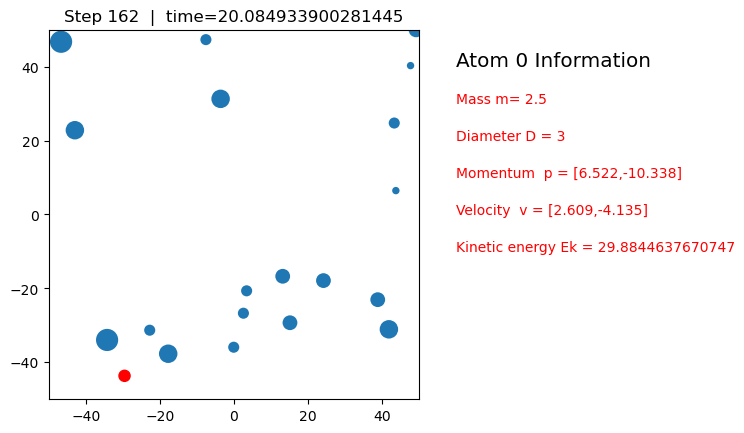

In [8]:
n=len(total_t)
print('Data size:',n)
for i in range(n):
    fig=plt.figure()
    ax = plt.gca()
    ax.set_aspect(1)
    plt.xlim((xmin, xmax))
    plt.ylim((ymin, ymax))

    for j,atom in enumerate(atoms):
        a,b=atom.path[i]
        r=atom.diameter/2
        if j==0:
            draw_circle = plt.Circle((a, b), r,color='r')
        else:
            draw_circle = plt.Circle((a, b), r)
        plt.gcf().gca().add_artist(draw_circle)
    plt.title('Step '+str(i)+'  |  time='+str(total_t[i]))
    plt.text(60,40,"Atom 0 Information",fontsize="x-large")
    plt.text(60,30,"Mass m= "+str(atoms[0].mass), color='r')
    plt.text(60,20,"Diameter D = "+str(atoms[0].diameter), color='r')
    plt.text(60,10,"Momentum  p = [%.3f,%.3f]"%(atoms[0].momentum[i][0],atoms[0].momentum[i][1]), color='r')
    plt.text(60,0,"Velocity  v = [%.3f,%.3f]"%(atoms[0].momentum[i][0]/atoms[0].mass,atoms[0].momentum[i][1]/atoms[0].mass), color='r')
    plt.text(60,-10,"Kinetic energy Ek = "+str(atoms[0].Ek[i]), color='r')
    newName = str(i)+".png"
    plt.savefig(newName,bbox_inches='tight')
    plt.close()

from PIL import Image
imgs = []
for t in range(n):
    img=Image.open(''+str(t)+'.png')
    imgs.append(img)
img.save('Hard Sphere Simulation.gif',save_all=True,append_images=imgs,duration=3)
img

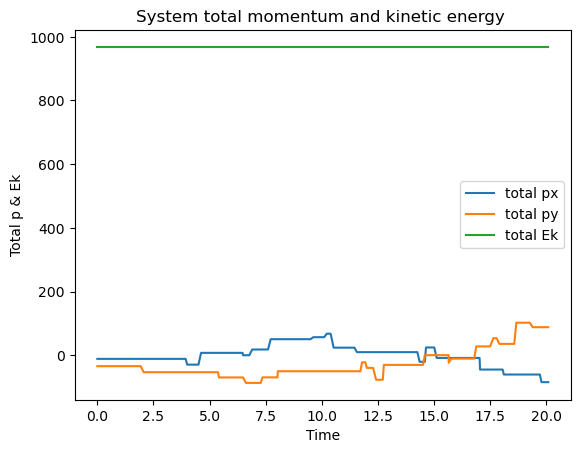

In [9]:
total_px,total_py,total_Ek=[],[],[]
for t in range(n):
    total_px.append( sum([atom.momentum[t][0] for atom in atoms]) )
    total_py.append( sum([atom.momentum[t][1] for atom in atoms]) )
    total_Ek.append( sum([atom.Ek[0] for atom in atoms]) )
fig=plt.figure()
plt.xlabel('Time')
plt.ylabel('Total p & Ek')
plt.plot(total_t,total_px)
plt.plot(total_t,total_py)
plt.plot(total_t,total_Ek)
plt.title('System total momentum and kinetic energy ')
plt.legend(['total px','total py','total Ek'])
    

In [10]:
import pandas as pd
df = pd.DataFrame()
n=len(atoms[0].path)
df[0]=total_t
for i in range(len(atoms)):
    df[2*i+1]=atoms[i].path
    df[2*i+2]=atoms[i].momentum

In [11]:
df

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0.000000,"[-2.1, -11.0]","[-13.5, 7.25]","[8.0, 3.8]","[13.6, 17.2]","[34.6, -23.2]","[-5.75, -1.0]","[39.3, 23.8]","[-5.3, -0.1]","[15.0, 20.2]",...,"[-25.7, -29.8]","[23.5, 30.5]","[3.2, 7.1]","[16.650000000000002, 12.15]","[-8.3, -35.2]","[-16.200000000000003, 11.100000000000001]","[-8.6, 37.0]","[-9.0, 9.45]","[-30.7, 39.6]","[4.25, -7.5]"
1,0.150000,"[-2.91, -10.565]","[-13.5, 7.25]","[8.51, 4.444999999999999]","[13.6, 17.2]","[34.255, -23.259999999999998]","[-5.75, -1.0]","[38.504999999999995, 23.785]","[-5.3, -0.1]","[15.36, 21.025]",...,"[-24.995, -28.885]","[23.5, 30.5]","[3.7550000000000003, 7.505]","[16.650000000000002, 12.15]","[-9.110000000000001, -34.645]","[-16.200000000000003, 11.100000000000001]","[-9.5, 37.945]","[-9.0, 9.45]","[-30.445, 39.15]","[4.25, -7.5]"
2,0.300000,"[-3.72, -10.129999999999999]","[-13.5, 7.25]","[9.02, 5.089999999999999]","[13.6, 17.2]","[33.910000000000004, -23.319999999999997]","[-5.75, -1.0]","[37.709999999999994, 23.77]","[-5.3, -0.1]","[15.719999999999999, 21.849999999999998]",...,"[-24.290000000000003, -27.970000000000002]","[23.5, 30.5]","[4.3100000000000005, 7.91]","[16.650000000000002, 12.15]","[-9.920000000000002, -34.09]","[-16.200000000000003, 11.100000000000001]","[-10.4, 38.89]","[-9.0, 9.45]","[-30.19, 38.699999999999996]","[4.25, -7.5]"
3,0.450000,"[-4.53, -9.694999999999999]","[-13.5, 7.25]","[9.53, 5.7349999999999985]","[13.6, 17.2]","[33.565000000000005, -23.379999999999995]","[-5.75, -1.0]","[36.91499999999999, 23.755]","[-5.3, -0.1]","[16.08, 22.674999999999997]",...,"[-23.585000000000004, -27.055000000000003]","[23.5, 30.5]","[4.865, 8.315]","[16.650000000000002, 12.15]","[-10.730000000000002, -33.535000000000004]","[-16.200000000000003, 11.100000000000001]","[-11.3, 39.835]","[-9.0, 9.45]","[-29.935000000000002, 38.24999999999999]","[4.25, -7.5]"
4,0.600000,"[-5.34, -9.259999999999998]","[-13.5, 7.25]","[10.04, 6.379999999999998]","[13.6, 17.2]","[33.220000000000006, -23.439999999999994]","[-5.75, -1.0]","[36.11999999999999, 23.74]","[-5.3, -0.1]","[16.439999999999998, 23.499999999999996]",...,"[-22.880000000000006, -26.140000000000004]","[23.5, 30.5]","[5.42, 8.719999999999999]","[16.650000000000002, 12.15]","[-11.540000000000003, -32.980000000000004]","[-16.200000000000003, 11.100000000000001]","[-12.200000000000001, 40.78]","[-9.0, 9.45]","[-29.680000000000003, 37.79999999999999]","[4.25, -7.5]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,19.561691,"[-30.955167919303488, -41.490908705541415]","[6.5224667816161075, -10.338266098243356]","[-0.5551811165532314, 32.76907133122431]","[-23.252096213230597, -11.350650825674101]","[41.24396155770013, -38.03819161957537]","[3.3121164551564384, 33.288991589502466]","[22.86978506093458, -15.722487063706739]","[2.6014897259764362, -4.13680575622251]","[-2.341520084075711, 46.69485791577915]",...,"[49.465409135103094, 49.6307060831364]","[11.973314327255473, 3.085586902120294]","[43.82080087539032, 24.302163942287088]","[-3.7478148630580046, 3.795821157843944]","[-33.441093873036046, -36.14004261634904]","[-4.959195553755182, 12.538261092243854]","[-46.91857493844929, 49.200899428467416]","[0.4606904260685539, -7.084133753521639]","[2.554875138997297, -19.085073774701172]","[4.25, -7.5]"
159,19.711691,"[-30.563819912406522, -42.11120467143601]","[6.5224667816161075, -10.338266098243356]","[-1.4271347245493788, 32.34342192526153]","[-23.252096213230597, -11.350650825674101]","[41.44268854500952, -36.04085212420522]","[3.3121164551564384, 33.288991589502466]","[23.260008519831043, -16.343007927140114]","[2.6014897259764362, -4.13680575622251]","[-3.8412456422045054, 46.870587419567116]",...,"[49.82460856492076, 49.72327369020001]","[11.973314327255473, 3.085586902120294]","[43.695873713288385, 24.428691314215218]","[-3.7478148630580046, 3.795821157843944]","[-33.68905365072381, -35.51312956173685]","[-4.959195553755182, 12